In [1]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
import illustris_python as il

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [3]:
def build_df_comparison(df_arr):
    ID = []
    z = []
    HaloMass = []
    Metallicity = []
    FractionStars = []
    FractionGas = []
    FractionDust = []
    Q0 = []
    aStar = []
    HaloRadii = []
    Q0_HaloMass = []
    R_v_3_HaloMass = []
    StarMass = []
    f_esc_no_dust = []
    f_esc_full = []
    f_esc_dust = []

    for _, element in df_arr[1].iterrows():
        halo_exist = []
        for df in df_arr:
            exist_in_df = len(df[(df.z==element.z)&(df.ID==element.ID)])
            halo_exist.append(exist_in_df)
        halo_exist = np.array(halo_exist)

        if ((halo_exist==1).all()):
            ID.append(element.ID)
            z.append(element.z)
            HaloMass.append(element.HaloMass)
            Metallicity.append(element.Metallicity)
            FractionStars.append(element.FractionStars)
            FractionGas.append(element.FractionGas)
            FractionDust.append(element.FractionDust)
            Q0.append(element.Q0)
            aStar.append(element.aStar)
            HaloRadii.append(element.HaloRadii)
            Q0_HaloMass.append(element['Q0/HaloMass'])
            R_v_3_HaloMass.append(element['R_v^3/HaloMass'])
            StarMass.append(element.StarMass)

            f_esc_no_dust.append(float(df_arr[0][(df_arr[0].z==element.z)&(df_arr[0].ID==element.ID)].f_esc))
            f_esc_full.append(float(df_arr[1][(df_arr[1].z==element.z)&(df_arr[1].ID==element.ID)].f_esc))
            f_esc_dust.append(float(df_arr[2][(df_arr[2].z==element.z)&(df_arr[2].ID==element.ID)].f_esc))
    df_comparison = pd.DataFrame({'ID':ID, 'z':z, 'HaloMass':HaloMass, 'Metallicity':Metallicity, 'FractionStars':FractionStars, 'FractionGas':FractionGas, 'FractionDust':FractionDust, 
                                  'Q0':Q0, 'aStar':aStar, 'HaloRadii':HaloRadii,'Q0/HaloMass':Q0_HaloMass, 'R_v^3/HaloMass':R_v_3_HaloMass, 'StarMass':StarMass,
                                  'f_esc_no_dust':f_esc_no_dust, 'f_esc_full':f_esc_full, 'f_esc_dust':f_esc_dust})
    return df_comparison

In [4]:
def update_df(df):
    #df.set_index('ID', inplace=True)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e4
    return

def get_dataframes():
    df_dust = pd.read_hdf('df_f_esc_freq.h5', 'dust')
    update_df(df_dust)

    df_no_dust = pd.read_hdf('df_f_esc_freq.h5', 'no_dust')
    update_df(df_no_dust)

    df_full_esc = pd.read_hdf('df_full_esc_freq.h5', 'no_dust')
    update_df(df_full_esc)
    df_arr = [df_no_dust, df_full_esc, df_dust]
    return df_arr

In [5]:
def plot_scatter(df, prop='StarMass', bins=20, mode='median', abs_esc=False):
    
    if prop == 'HaloMass':
        halo_prop = 'HaloMass'
        x_label = 'Halo Mass [$10^{10}M_{\mathrm{sun}}$]'
    elif prop == 'StarMass':    
        halo_prop = 'StarMass'
        x_label = 'Stellar Mass [$10^{6}M_{\mathrm{sun}}$]'
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
    
    if abs_esc:
        loc_escs = np.array([0.1,0.3,0.5,0.7,1.0])
    else:
        loc_escs = np.ones(5)
    
    x_values = df.loc[:,halo_prop]
    edges = np.logspace(np.log10(x_values.min()),np.log10(x_values.max()), bins)
    f_escs = ['f_esc_no_dust', 'f_esc_full', 'f_esc_dust']
    labels = ['no dust', 'full escape', 'dust', '0.7', '1.0']
    
    fig, ax1 = plt.subplots()
    for j, esc in enumerate(f_escs):     
        means = []
        error = []
        centers = []
        variance = []
        for i in range(len(edges)-1):
            sub_fesc = df[(edges[i]*(1-1e-10)<df[halo_prop]) & (df[halo_prop]<edges[i+1])][esc]*loc_escs[j]
            centers.append(np.exp((np.log(edges[i+1])+np.log(edges[i]))/2.))

            if mode == 'median':
                means.append(sub_fesc.median())
            elif mode == 'mean':
                means.append(sub_fesc.mean())

            error.append(sub_fesc.std()/np.sqrt(sub_fesc.shape[0]))
            variance.append(sub_fesc.var())
            
        #ax1.scatter(x_values, f_esc)
        ax1.errorbar(centers, means, yerr=error, linewidth=3, elinewidth=2, capsize=10, label='$f_\mathrm{esc,loc}=$'+labels[j])
    ax1.set_xscale('log')
    ax1.set_yscale('symlog', linthreshy=1e-3)
    ax1.set_ylim(0,1)
    ax1.set_ylabel(r'$ \langle f_\mathrm{esc} \rangle $', size=35)
    if prop== 'StarMass':
        ax1.set_xlabel('$M_\mathrm{star}[10^6M_\mathrm{sun}]$', size=35)
    elif prop == 'HaloMass':
        ax1.set_xlabel('$M_\mathrm{halo}[10^{10}M_\mathrm{sun}]$', size=35)
    ax1.legend(fontsize=25)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.show();

In [6]:
def intersect(df_dust, df_no_dust):
    df_intersect = pd.merge(df_dust, df_no_dust, how='inner', on=['HaloMass', 'StarMass'], suffixes=('_dust', '_no_dust'), left_index=True)
    return df_intersect

In [7]:
def plot_comparisons(df_dust, df_no_dust, halo_prop=['HaloMass', 'StarMass'], x_axis_labels=None, titles=None):
    dataframe = intersect(df_dust, df_no_dust)
    
    if x_axis_labels == None:
        x_axis_labels = halo_prop
    
    figure, subfigs = plt.subplots(len(halo_prop))
    rel_difference = (dataframe.loc[:,'f_esc_no_dust']-dataframe.loc[:,'f_esc_dust'])#/dataframe['f_esc_no_dust']
    for i,prop in enumerate(halo_prop):
        data = dataframe.loc[:,prop]    
            
        subfigs[i].scatter(dataframe.loc[:,prop], rel_difference, s=200)
        subfigs[i].set_xscale('log')
        subfigs[i].set_xlim((dataframe.loc[:,prop].min(),dataframe.loc[:,prop].max()))
        
        #subfigs[i].set_ylabel(r'$\frac{f_{\mathrm{esc}_{\mathrm{no\_dust}}}-f_{\mathrm{esc}_{\mathrm{dust}}}}{f_{\mathrm{esc}_{\mathrm{no\_dust}}}}$', size='25')
        subfigs[i].set_xlabel(x_axis_labels[i], size='25')

        #subfigs[i].legend(fontsize=20)
        
        if titles!=None:
            subfigs[i].set_title(titles[i],fontsize=30)
        plt.rcParams["figure.figsize"] = (20,20*len(halo_prop))
    plt.show();

In [8]:
df = pd.read_hdf('df_f_esc_freq.h5', 'no_dust')
update_df(df)

FileNotFoundError: File df_f_esc_freq.h5 does not exist

In [83]:
for i,row in intersect(df_dust[df_dust.z==8], df_no_dust[df_no_dust.z==8]).iterrows():
    if row['f_esc_no_dust']-row['f_esc_dust']>0.0010:
        print(row['ID_dust'])
        #break

1140
8289
3456
71
5130
38
17317


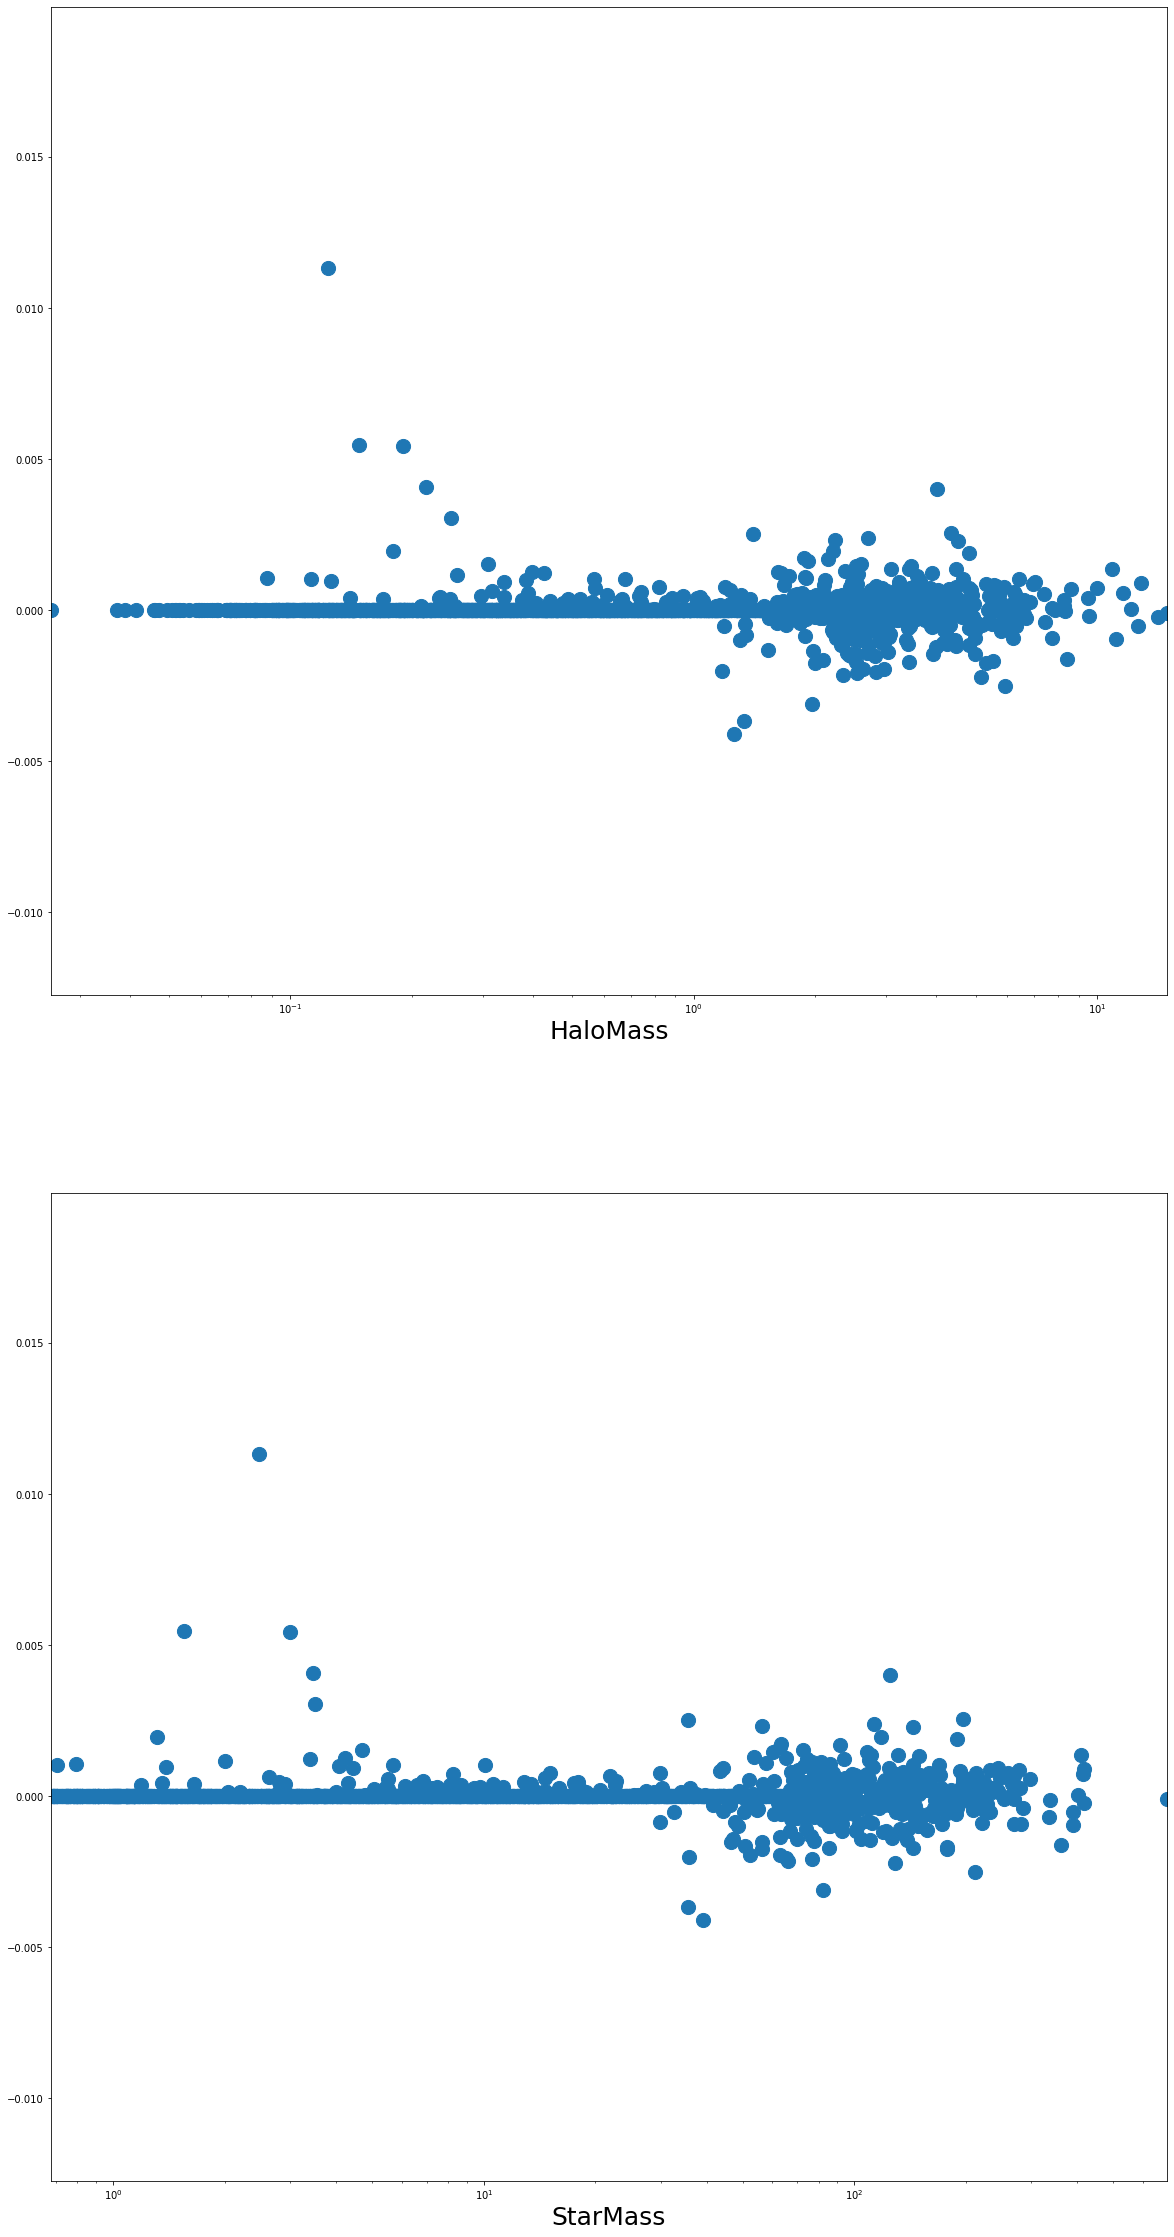

In [86]:
plot_comparisons(df_dust, df_no_dust)

In [37]:
d_nd = build_df_comparison(df_arr)

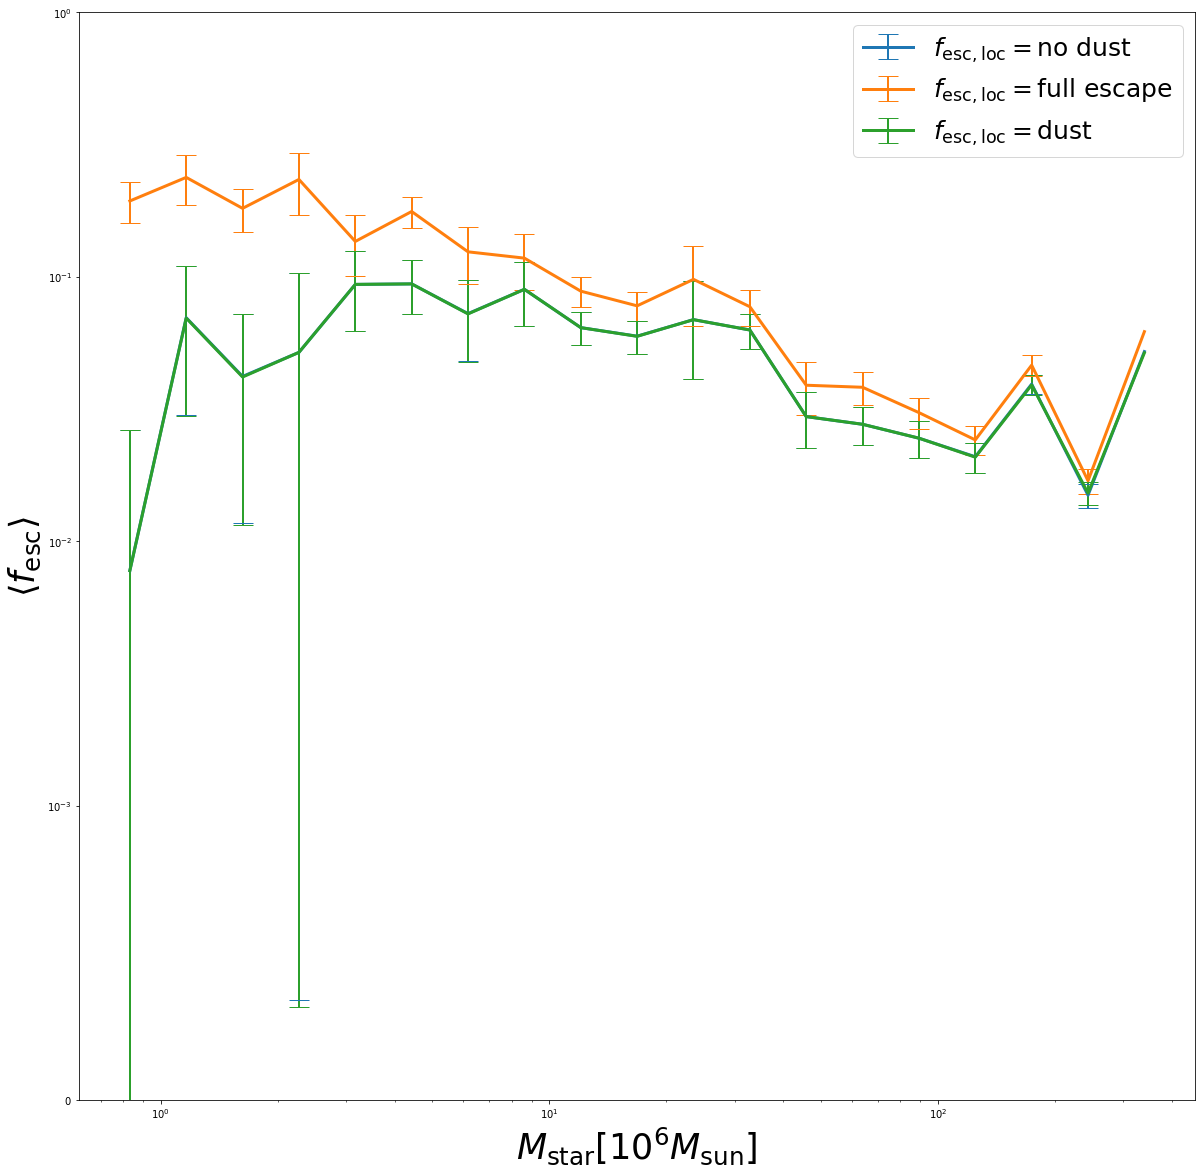

In [46]:
plot_scatter(df[df.z==8])